

# **Filter & Class Maximisation**

---


In this lesson, we use **Keras with a TensorFlow 2.0** to visualise the following (see below). This helps you gain a better understanding of what's going on under the hood and de-mystifies some of the deep learning aspects.**
1. Filter Maximisation
2. Class Maximisation

**References:**

https://github.com/keisen/tf-keras-vis



## **Maximizing Filter Activations**

The process is relatively simple in principle.
1. You’ll build a loss function that maximizes the value of a given filter in a given convolution layer for a specific input image.
2. You’ll use Stochastic Gradient Descent to adjust the values of the input image so as to maximize this activation value (filter values).


**NOTE** This is easier to implement in TF1.14 so we'll downgrade our Tensorflow package to make this work.

# **Visualising Conv Filters Maximisations**

Firstly, we need to install tf-keras-vis. https://github.com/keisen/tf-keras-vis

In [1]:
!pip install --upgrade tf-keras-vis tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 4.1 MB/s eta 0:00:00


**Import our libraries**

In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('{} GPUs'.format(gpus))

1 GPUs


### **Load a pretrained VGG16 model.**

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model

# Load model
model = Model(weights='imagenet', include_top=True)
model.summary()

553467096/553467096 [==============================] - 17s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

#### **Firstly, we define a function to modify the model**

Define modifier to replace the model output to target layer's output that has filters you want to visualize.

In [4]:
layer_name = 'block5_conv3' # The target layer that is the last layer of VGG16.

def model_modifier(current_model):
    target_layer = current_model.get_layer(name=layer_name)
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    new_model.layers[-1].activation = tf.keras.activations.linear
    return new_model

### **Create ActivationMaximization Instance**

If clone argument is True(default), the model will be cloned, so the model instance will be NOT modified, but it takes a machine resources.

In [5]:
from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(model, model_modifier, clone=False)

### **Define Loss function**
You MUST define Loss function that return arbitrary filter values. Here, it returns the value corresponding third filter in block5_conv3 layer. ActivationMaximization will maximize the filter value.

In [6]:
filter_number = 7
def loss(output):
    return output[..., filter_number]

### **Visualize**
ActivationMaximization will maximize the model output value that is computed by the loss function. Here, we try to visualize a convolutional filter.

<timed exec>:4: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.


Steps: 050	Scores: [[585.0270385742188]],	Regularization: [('TotalVariation2D', [10.327320098876953]), ('Norm', [38.45618438720703])]
Steps: 100	Scores: [[846.3801879882812]],	Regularization: [('TotalVariation2D', [11.25512409210205]), ('Norm', [38.81877899169922])]
Steps: 150	Scores: [[968.3465576171875]],	Regularization: [('TotalVariation2D', [11.707049369812012]), ('Norm', [39.24679183959961])]
Steps: 200	Scores: [[924.4572143554688]],	Regularization: [('TotalVariation2D', [10.375131607055664]), ('Norm', [39.6065788269043])]


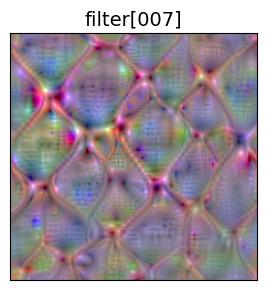

The input image which maximizes the filter: 7
CPU times: user 11.3 s, sys: 167 ms, total: 11.4 s
Wall time: 11.4 s


In [9]:
%%time
from tf_keras_vis.utils.callbacks import Print

# Generate max activation
activation = activation_maximization(loss, callbacks=[Print(interval=50)])
image = activation[0].numpy().astype(np.uint8)

# Render
subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (3, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }

f, ax = plt.subplots(**subplot_args)
ax.imshow(image)
ax.set_title('filter[{:03d}]'.format(filter_number), fontsize=14)
plt.tight_layout()
plt.show()
print('The input image which maximizes the filter: {0}'.format(filter_number))

## **Now let's visualize multiple convolutional filters**

#### **Define Loss function**
When visualizing multiple convolutional filters, you MUST define Loss function that return arbitrary filter values for each layer.

In [10]:
filter_numbers = [63, 132, 320]

# Define loss function that returns multiple filter outputs.
def loss(output):
    return (output[0, ..., 63], output[1, ..., 132], output[2, ..., 320])

#### **Create SeedInput values**

And then, you MUST prepare seed-input value. In default, when visualizing a conv filter, tf-keras-vis automatically generate seed-input for generating a image. When visualizing multiple conv filters, you MUST manually generate seed-input whose samples-dim is as many as the number of the filters you want to generate.

In [11]:
# Define seed inputs whose shape is (samples, height, width, channels).

seed_input = tf.random.uniform((3, 224, 224, 3), 0, 255)


#### **Visualize**

Here, we will visualize 3 images while steps option is to be 512 to get clear images.

<timed exec>:4: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.


Steps: 050	Scores: [[330.1140441894531, 317.76226806640625, 343.2271728515625]],	Regularization: [('TotalVariation2D', [7.973752498626709, 7.841153144836426, 7.89811372756958]), ('Norm', [38.261478424072266, 38.26713943481445, 38.31121063232422])]
Steps: 100	Scores: [[523.7781982421875, 432.1300964355469, 548.8809814453125]],	Regularization: [('TotalVariation2D', [9.450542449951172, 8.50484848022461, 9.361659049987793]), ('Norm', [38.47260665893555, 38.43147277832031, 38.56123352050781])]
Steps: 150	Scores: [[604.9274291992188, 443.619873046875, 600.6836547851562]],	Regularization: [('TotalVariation2D', [9.884017944335938, 8.13908863067627, 9.571575164794922]), ('Norm', [38.67286682128906, 38.58562088012695, 38.83199691772461])]
Steps: 200	Scores: [[578.38671875, 436.22003173828125, 567.641845703125]],	Regularization: [('TotalVariation2D', [9.12506103515625, 7.496672630310059, 8.725717544555664]), ('Norm', [38.874664306640625, 38.716461181640625, 39.06302261352539])]


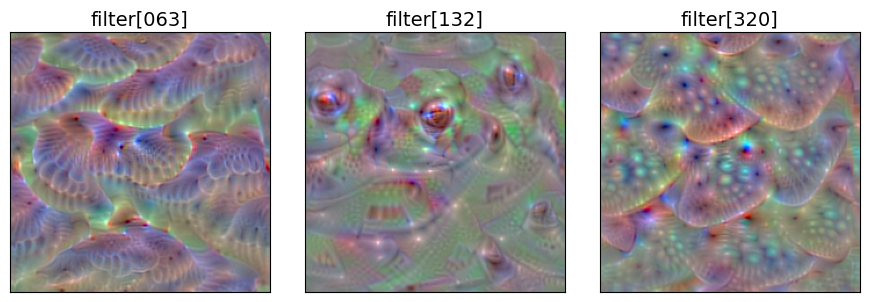

CPU times: user 22.2 s, sys: 301 ms, total: 22.5 s
Wall time: 23.1 s


In [13]:
%%time

# Generate max activation
activations = activation_maximization(loss,
                                      seed_input=seed_input, # To generate multiple images
                                      callbacks=[Print(interval=50)])
images = [activation.numpy().astype(np.uint8) for activation in activations]

# Render
subplot_args = { 'nrows': 1, 'ncols': 3, 'figsize': (9, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, filter_number in enumerate(filter_numbers):
    ax[i].set_title('filter[{:03d}]'.format(filter_number), fontsize=14)
    ax[i].imshow(images[i])

plt.tight_layout()
plt.show()

# **Class Maximisation**

Finding an input image that maximizes a specific class of VGGNet.

#### **Load libaries and load your pretrained VGG16 Model**

Load tf.keras.Model¶
This tutorial use VGG16 model in tf.keras but if you want to use other tf.keras.Models, you can do so by modifing section below.


In [14]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('{} GPUs'.format(gpus))

from tensorflow.keras.applications.vgg16 import VGG16 as Model

# Load model
model = Model(weights='imagenet', include_top=True)
model.summary()

1 GPUs
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

#### **Define a function to modify the model**

Define modifier to replace a softmax function of the last layer to a linear function.

In [15]:
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear

#### **Create ActivationMaximization Instance**

If clone argument is True(default), the model will be cloned, so the model instance will be NOT modified, but it takes a machine resources.

In [16]:
from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(model,
                                                 model_modifier,
                                                 clone=False)

#### **Define Loss function**

You MUST define Loss function that return arbitrary category value. Here, we try to visualize a category as defined No.20 (ouzel) of imagenet.



In [17]:
def loss(output):
    return output[:, 20]

### **Visualise**

The Imagenet Classes - https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

<timed exec>:4: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.


Steps: 050	Scores: [[46.78270721435547]],	Regularization: [('TotalVariation2D', [4.441522598266602]), ('Norm', [38.10095977783203])]
Steps: 100	Scores: [[92.80046844482422]],	Regularization: [('TotalVariation2D', [4.625779151916504]), ('Norm', [38.051143646240234])]
Steps: 150	Scores: [[121.01309967041016]],	Regularization: [('TotalVariation2D', [4.96365213394165]), ('Norm', [38.0290641784668])]
Steps: 200	Scores: [[174.5217742919922]],	Regularization: [('TotalVariation2D', [5.850795269012451]), ('Norm', [38.04896926879883])]


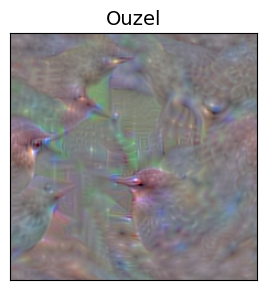

CPU times: user 12.7 s, sys: 193 ms, total: 12.9 s
Wall time: 12.9 s


In [18]:
%%time

from tf_keras_vis.utils.callbacks import Print

activation = activation_maximization(loss,
                                     callbacks=[Print(interval=50)])
image = activation[0].numpy().astype(np.uint8)

subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (3, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
ax.imshow(image)
ax.set_title('Ouzel', fontsize=14)
plt.tight_layout()
plt.show()


### **Visualizing specific output categories**

Now, let's visualize multiple categories at once!

#### **Define Loss function**

You MUST define loss function that return arbitrary category values. Here, we try to visualize categories as defined No.1 (Goldfish), No.294 (Bear) and No.413 (Assault rifle) of imagenet.


In [19]:
image_titles = ['Goldfish', 'Bear', 'Assault rifle']

def loss(output):
    return (output[0, 1], output[1, 294], output[2, 413])

#### **Create SeedInput values**
And then, you MUST prepare seed-input value. In default, when visualizing a conv filter, tf-keras-vis automatically generate seed-input for generating a image. When visualizing multiple conv filters, you MUST manually generate seed-input whose samples-dim is as many as the number of the filters you want to generate.

In [20]:
# Define seed inputs whose shape is (samples, height, width, channels).

seed_input = tf.random.uniform((3, 224, 224, 3), 0, 255)

#### **Visualize**

Here, we will visualize 3 images while steps option is to be 512 to get clear images.

<timed exec>:5: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.


Steps: 050	Scores: [[127.34259033203125, 57.3173828125, 18.409061431884766]],	Regularization: [('TotalVariation2D', [5.548249244689941, 4.2856011390686035, 3.6835949420928955]), ('Norm', [38.18254852294922, 38.19505310058594, 38.12800979614258])]
Steps: 100	Scores: [[192.14524841308594, 99.47083282470703, 72.19686889648438]],	Regularization: [('TotalVariation2D', [5.9823431968688965, 4.470459938049316, 3.904695510864258]), ('Norm', [38.21512985229492, 38.16372299194336, 38.06663131713867])]
Steps: 150	Scores: [[207.67042541503906, 130.06336975097656, 83.85179901123047]],	Regularization: [('TotalVariation2D', [6.2397356033325195, 5.079789161682129, 4.0292181968688965]), ('Norm', [38.294979095458984, 38.16532516479492, 38.02025604248047])]
Steps: 200	Scores: [[251.99746704101562, 142.21424865722656, 91.46324157714844]],	Regularization: [('TotalVariation2D', [6.23900032043457, 5.099283218383789, 4.189699649810791]), ('Norm', [38.37251663208008, 38.17144775390625, 37.97113037109375])]
Step

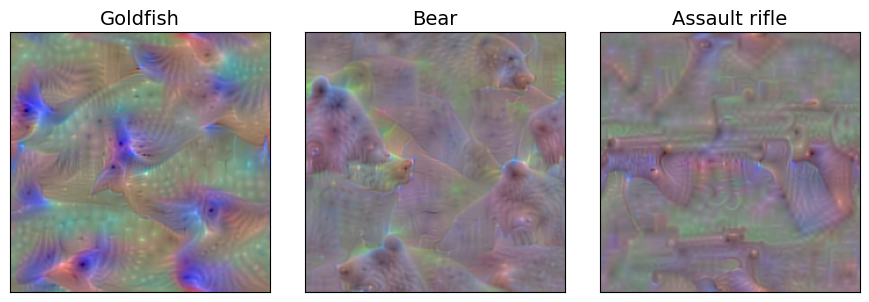

CPU times: user 58.1 s, sys: 480 ms, total: 58.6 s
Wall time: 1min


In [22]:
%%time

# Do 500 iterations and Generate an optimizing animation
activations = activation_maximization(loss,
                                      seed_input=seed_input,
                                      steps=512,
                                      callbacks=[ Print(interval=50)])
images = [activation.numpy().astype(np.uint8) for activation in activations]

# Render
subplot_args = { 'nrows': 1, 'ncols': 3, 'figsize': (9, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
plt.tight_layout()

plt.show()